In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "z"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.57it/s]

13it [00:00,  5.04it/s]

25it [00:00,  7.06it/s]

37it [00:00,  9.82it/s]

47it [00:00, 13.45it/s]

59it [00:00, 18.28it/s]

71it [00:00, 24.45it/s]

83it [00:01, 32.01it/s]

95it [00:01, 40.84it/s]

106it [00:01, 50.01it/s]

118it [00:01, 59.80it/s]

130it [00:01, 69.56it/s]

142it [00:01, 78.86it/s]

154it [00:01, 86.73it/s]

166it [00:01, 93.43it/s]

178it [00:01, 98.99it/s]

190it [00:01, 102.65it/s]

202it [00:02, 105.31it/s]

214it [00:02, 107.41it/s]

226it [00:02, 109.26it/s]

238it [00:02, 110.17it/s]

250it [00:02, 110.68it/s]

262it [00:02, 111.21it/s]

274it [00:02, 111.40it/s]

286it [00:02, 109.51it/s]

298it [00:02, 110.40it/s]

310it [00:03, 101.93it/s]

321it [00:03, 101.14it/s]

332it [00:03, 101.11it/s]

343it [00:03, 100.36it/s]

354it [00:03, 99.85it/s] 

366it [00:03, 103.10it/s]

377it [00:03, 103.02it/s]

389it [00:03, 106.07it/s]

400it [00:03, 105.25it/s]

411it [00:04, 103.68it/s]

423it [00:04, 106.30it/s]

435it [00:04, 107.53it/s]

447it [00:04, 108.52it/s]

459it [00:04, 109.67it/s]

471it [00:04, 110.25it/s]

483it [00:04, 106.58it/s]

495it [00:04, 108.33it/s]

506it [00:04, 103.95it/s]

517it [00:05, 104.93it/s]

529it [00:05, 107.33it/s]

541it [00:05, 106.94it/s]

552it [00:05, 103.26it/s]

563it [00:05, 95.78it/s] 

575it [00:05, 101.13it/s]

587it [00:05, 105.08it/s]

599it [00:05, 107.94it/s]

610it [00:05, 100.55it/s]

621it [00:06, 91.73it/s] 

631it [00:06, 89.96it/s]

643it [00:06, 96.24it/s]

655it [00:06, 101.13it/s]

666it [00:06, 96.15it/s] 

678it [00:06, 100.47it/s]

689it [00:06, 91.17it/s] 

701it [00:06, 97.14it/s]

713it [00:07, 101.50it/s]

725it [00:07, 104.78it/s]

737it [00:07, 107.73it/s]

749it [00:07, 109.88it/s]

761it [00:07, 110.74it/s]

773it [00:07, 112.54it/s]

785it [00:07, 113.23it/s]

797it [00:07, 113.37it/s]

809it [00:07, 113.68it/s]

821it [00:07, 112.41it/s]

833it [00:08, 111.34it/s]

845it [00:08, 111.13it/s]

857it [00:08, 111.32it/s]

869it [00:08, 112.49it/s]

881it [00:08, 113.08it/s]

893it [00:08, 113.80it/s]

905it [00:08, 114.05it/s]

917it [00:08, 113.49it/s]

929it [00:08, 114.04it/s]

941it [00:09, 113.49it/s]

953it [00:09, 113.41it/s]

965it [00:09, 113.55it/s]

977it [00:09, 99.59it/s] 

988it [00:09, 91.74it/s]

998it [00:09, 86.73it/s]

1009it [00:09, 92.22it/s]

1021it [00:09, 97.59it/s]

1033it [00:09, 101.52it/s]

1045it [00:10, 104.60it/s]

1057it [00:10, 107.32it/s]

1069it [00:10, 109.33it/s]

1081it [00:10, 107.24it/s]

1093it [00:10, 109.70it/s]

1105it [00:10, 111.04it/s]

1117it [00:10, 112.05it/s]

1129it [00:10, 101.44it/s]

1141it [00:10, 105.07it/s]

1152it [00:11, 97.23it/s] 

1162it [00:11, 93.85it/s]

1174it [00:11, 99.20it/s]

1186it [00:11, 103.76it/s]

1198it [00:11, 106.90it/s]

1210it [00:11, 109.27it/s]

1222it [00:11, 110.61it/s]

1234it [00:11, 111.81it/s]

1246it [00:11, 99.11it/s] 

1257it [00:12, 101.61it/s]

1268it [00:12, 102.76it/s]

1279it [00:12, 104.81it/s]

1291it [00:12, 106.71it/s]

1303it [00:12, 108.04it/s]

1315it [00:12, 108.91it/s]

1326it [00:12, 108.59it/s]

1338it [00:12, 109.30it/s]

1349it [00:12, 108.90it/s]

1361it [00:13, 109.89it/s]

1373it [00:13, 109.19it/s]

1384it [00:13, 98.83it/s] 

1395it [00:13, 90.71it/s]

1405it [00:13, 86.84it/s]

1415it [00:13, 89.76it/s]

1426it [00:13, 94.96it/s]

1438it [00:13, 99.33it/s]

1449it [00:14, 89.41it/s]

1459it [00:14, 86.32it/s]

1468it [00:14, 83.54it/s]

1479it [00:14, 88.92it/s]

1491it [00:14, 94.99it/s]

1503it [00:14, 99.17it/s]

1515it [00:14, 102.73it/s]

1527it [00:14, 105.99it/s]

1539it [00:14, 108.53it/s]

1551it [00:15, 109.73it/s]

1563it [00:15, 104.82it/s]

1575it [00:15, 106.64it/s]

1586it [00:15, 102.64it/s]

1597it [00:15, 104.31it/s]

1609it [00:15, 106.17it/s]

1620it [00:15, 90.51it/s] 

1631it [00:15, 93.56it/s]

1642it [00:15, 97.91it/s]

1654it [00:16, 101.47it/s]

1666it [00:16, 104.02it/s]

1678it [00:16, 106.07it/s]

1690it [00:16, 107.52it/s]

1702it [00:16, 109.63it/s]

1714it [00:16, 110.26it/s]

1726it [00:16, 110.38it/s]

1738it [00:16, 110.98it/s]

1750it [00:16, 111.34it/s]

1762it [00:17, 110.80it/s]

1774it [00:17, 110.41it/s]

1786it [00:17, 110.36it/s]

1798it [00:17, 111.07it/s]

1810it [00:17, 111.07it/s]

1822it [00:17, 111.13it/s]

1834it [00:17, 109.39it/s]

1845it [00:17, 96.37it/s] 

1855it [00:17, 92.92it/s]

1865it [00:18, 94.50it/s]

1877it [00:18, 98.88it/s]

1889it [00:18, 102.32it/s]

1900it [00:18, 92.72it/s] 

1911it [00:18, 97.23it/s]

1923it [00:18, 101.30it/s]

1935it [00:18, 104.44it/s]

1946it [00:18, 103.19it/s]

1958it [00:18, 105.70it/s]

1969it [00:19, 105.68it/s]

1980it [00:19, 106.36it/s]

1992it [00:19, 107.86it/s]

2003it [00:19, 96.01it/s] 

2013it [00:19, 86.24it/s]

2023it [00:19, 82.63it/s]

2034it [00:19, 88.33it/s]

2046it [00:19, 94.32it/s]

2056it [00:20, 80.36it/s]

2067it [00:20, 85.75it/s]

2077it [00:20, 87.52it/s]

2089it [00:20, 93.45it/s]

2099it [00:20, 85.95it/s]

2108it [00:20, 83.38it/s]

2117it [00:20, 81.21it/s]

2127it [00:20, 85.20it/s]

2139it [00:20, 92.09it/s]

2150it [00:21, 96.42it/s]

2161it [00:21, 99.95it/s]

2172it [00:21, 101.26it/s]

2183it [00:21, 89.75it/s] 

2195it [00:21, 95.36it/s]

2206it [00:21, 99.11it/s]

2217it [00:21, 97.31it/s]

2229it [00:21, 101.61it/s]

2241it [00:21, 104.63it/s]

2252it [00:22, 102.42it/s]

2263it [00:22, 89.37it/s] 

2273it [00:22, 89.17it/s]

2285it [00:22, 94.97it/s]

2297it [00:22, 99.35it/s]

2309it [00:22, 103.00it/s]

2321it [00:22, 105.82it/s]

2333it [00:22, 107.91it/s]

2344it [00:22, 108.34it/s]

2355it [00:23, 104.24it/s]

2366it [00:23, 105.75it/s]

2377it [00:23, 106.11it/s]

2388it [00:23, 106.99it/s]

2400it [00:23, 108.08it/s]

2411it [00:23, 108.40it/s]

2423it [00:23, 109.13it/s]

2434it [00:23, 108.44it/s]

2446it [00:23, 109.37it/s]

2457it [00:24, 109.14it/s]

2469it [00:24, 109.95it/s]

2481it [00:24, 110.01it/s]

2493it [00:24, 109.79it/s]

2504it [00:24, 108.16it/s]

2516it [00:24, 109.16it/s]

2527it [00:24, 109.27it/s]

2539it [00:24, 110.44it/s]

2551it [00:24, 110.64it/s]

2563it [00:24, 108.94it/s]

2574it [00:25, 109.22it/s]

2585it [00:25, 95.17it/s] 

2596it [00:25, 97.00it/s]

2607it [00:25, 100.49it/s]

2618it [00:25, 95.40it/s] 

2630it [00:25, 99.40it/s]

2642it [00:25, 102.85it/s]

2653it [00:25, 98.51it/s] 

2664it [00:26, 101.65it/s]

2676it [00:26, 104.79it/s]

2688it [00:26, 106.22it/s]

2700it [00:26, 108.16it/s]

2712it [00:26, 109.73it/s]

2724it [00:26, 110.18it/s]

2736it [00:26, 110.27it/s]

2748it [00:26, 109.02it/s]

2759it [00:26, 108.66it/s]

2770it [00:26, 108.74it/s]

2781it [00:27, 108.30it/s]

2792it [00:27, 89.09it/s] 

2802it [00:27, 84.87it/s]

2811it [00:27, 82.25it/s]

2820it [00:27, 80.92it/s]

2829it [00:27, 79.53it/s]

2840it [00:27, 85.37it/s]

2852it [00:27, 92.13it/s]

2864it [00:28, 97.57it/s]

2875it [00:28, 100.86it/s]

2886it [00:28, 103.24it/s]

2898it [00:28, 105.62it/s]

2909it [00:28, 106.84it/s]

2920it [00:28, 107.54it/s]

2932it [00:28, 109.68it/s]

2944it [00:28, 110.09it/s]

2956it [00:28, 101.51it/s]

2968it [00:29, 104.77it/s]

2980it [00:29, 106.80it/s]

2992it [00:29, 107.84it/s]

3004it [00:29, 109.53it/s]

3016it [00:29, 110.80it/s]

3028it [00:29, 111.70it/s]

3040it [00:29, 111.99it/s]

3052it [00:29, 111.83it/s]

3064it [00:29, 111.77it/s]

3076it [00:29, 111.82it/s]

3088it [00:30, 111.83it/s]

3100it [00:30, 109.29it/s]

3112it [00:30, 110.17it/s]

3124it [00:30, 110.97it/s]

3136it [00:30, 112.16it/s]

3148it [00:30, 103.01it/s]

3160it [00:30, 106.23it/s]

3172it [00:30, 108.25it/s]

3184it [00:30, 109.04it/s]

3195it [00:31, 108.91it/s]

3207it [00:31, 109.93it/s]

3219it [00:31, 109.03it/s]

3231it [00:31, 109.74it/s]

3243it [00:31, 110.30it/s]

3255it [00:31, 110.46it/s]

3267it [00:31, 111.51it/s]

3279it [00:31, 111.55it/s]

3291it [00:31, 111.27it/s]

3303it [00:32, 110.65it/s]

3315it [00:32, 111.10it/s]

3327it [00:32, 110.15it/s]

3339it [00:32, 110.49it/s]

3351it [00:32, 109.45it/s]

3362it [00:32, 109.39it/s]

3373it [00:32, 105.88it/s]

3385it [00:32, 107.64it/s]

3397it [00:32, 109.61it/s]

3409it [00:33, 110.69it/s]

3421it [00:33, 111.45it/s]

3433it [00:33, 111.77it/s]

3445it [00:33, 111.11it/s]

3457it [00:33, 111.45it/s]

3469it [00:33, 110.97it/s]

3481it [00:33, 111.15it/s]

3493it [00:33, 111.31it/s]

3505it [00:33, 111.27it/s]

3517it [00:34, 103.54it/s]

3528it [00:34, 99.96it/s] 

3540it [00:34, 103.60it/s]

3552it [00:34, 106.50it/s]

3564it [00:34, 108.28it/s]

3576it [00:34, 109.67it/s]

3588it [00:34, 110.84it/s]

3600it [00:34, 111.95it/s]

3612it [00:34, 112.06it/s]

3624it [00:34, 111.68it/s]

3636it [00:35, 109.72it/s]

3647it [00:35, 107.55it/s]

3658it [00:35, 106.85it/s]

3669it [00:35, 106.04it/s]

3680it [00:35, 106.32it/s]

3691it [00:35, 105.34it/s]

3702it [00:35, 106.64it/s]

3713it [00:35, 101.37it/s]

3724it [00:35, 93.59it/s] 

3735it [00:36, 97.87it/s]

3745it [00:36, 95.89it/s]

3755it [00:36, 96.54it/s]

3765it [00:36, 95.31it/s]

3776it [00:36, 99.28it/s]

3788it [00:36, 102.96it/s]

3799it [00:36, 95.05it/s] 

3810it [00:36, 95.86it/s]

3820it [00:37, 77.52it/s]

3829it [00:37, 68.64it/s]

3837it [00:37, 66.41it/s]

3848it [00:37, 74.21it/s]

3859it [00:37, 80.87it/s]

3870it [00:37, 85.98it/s]

3880it [00:37, 89.72it/s]

3890it [00:37, 90.32it/s]

3901it [00:37, 94.73it/s]

3912it [00:38, 95.36it/s]

3922it [00:38, 87.22it/s]

3931it [00:38, 87.93it/s]

3942it [00:38, 92.32it/s]

3953it [00:38, 94.62it/s]

3964it [00:38, 98.55it/s]

3975it [00:38, 100.28it/s]

3986it [00:38, 102.30it/s]

3997it [00:38, 101.36it/s]

4008it [00:39, 75.13it/s] 

4017it [00:39, 68.34it/s]

4028it [00:39, 75.98it/s]

4037it [00:39, 79.11it/s]

4048it [00:39, 85.92it/s]

4058it [00:39, 82.84it/s]

4068it [00:39, 86.65it/s]

4080it [00:40, 93.02it/s]

4092it [00:40, 97.76it/s]

4104it [00:40, 102.30it/s]

4115it [00:40, 98.09it/s] 

4126it [00:40, 100.73it/s]

4137it [00:40, 102.67it/s]

4148it [00:40, 85.27it/s] 

4158it [00:40, 85.30it/s]

4160it [00:40, 101.77it/s]


0it [00:00, ?it/s]

11it [00:00, 108.17it/s]

Number of empty sat catalogs is 10


22it [00:00, 104.36it/s]

28it [00:00, 76.25it/s] 

35it [00:00, 73.68it/s]

43it [00:00, 74.03it/s]

50it [00:00, 69.59it/s]

60it [00:00, 75.70it/s]

72it [00:00, 84.86it/s]

84it [00:00, 92.12it/s]

96it [00:01, 98.44it/s]

107it [00:01, 97.21it/s]

117it [00:01, 85.85it/s]

127it [00:01, 88.68it/s]

139it [00:01, 94.51it/s]

151it [00:01, 98.97it/s]

163it [00:01, 102.30it/s]

174it [00:01, 95.57it/s] 

184it [00:02, 88.23it/s]

196it [00:02, 95.04it/s]

208it [00:02, 99.67it/s]

219it [00:02, 100.62it/s]

230it [00:02, 92.94it/s] 

240it [00:02, 93.68it/s]

252it [00:02, 98.73it/s]

264it [00:02, 102.47it/s]

275it [00:02, 101.39it/s]

288it [00:03, 106.42it/s]

300it [00:03, 109.91it/s]

312it [00:03, 111.96it/s]

324it [00:03, 112.79it/s]

336it [00:03, 113.90it/s]

348it [00:03, 113.91it/s]

360it [00:03, 114.79it/s]

372it [00:03, 115.54it/s]

384it [00:03, 115.24it/s]

397it [00:03, 117.04it/s]

409it [00:04, 117.79it/s]

421it [00:04, 117.15it/s]

433it [00:04, 117.92it/s]

445it [00:04, 118.40it/s]

457it [00:04, 115.61it/s]

470it [00:04, 117.27it/s]

483it [00:04, 118.29it/s]

495it [00:04, 116.40it/s]

507it [00:04, 117.21it/s]

519it [00:05, 117.91it/s]

531it [00:05, 117.23it/s]

543it [00:05, 113.39it/s]

555it [00:05, 115.10it/s]

567it [00:05, 116.07it/s]

580it [00:05, 117.66it/s]

593it [00:05, 118.81it/s]

605it [00:05, 118.38it/s]

617it [00:05, 117.32it/s]

629it [00:05, 102.39it/s]

641it [00:06, 105.38it/s]

654it [00:06, 109.93it/s]

666it [00:06, 112.25it/s]

678it [00:06, 114.16it/s]

690it [00:06, 115.51it/s]

702it [00:06, 112.89it/s]

714it [00:06, 83.65it/s] 

726it [00:06, 91.79it/s]

739it [00:07, 99.13it/s]

752it [00:07, 104.68it/s]

764it [00:07, 107.99it/s]

776it [00:07, 106.35it/s]

789it [00:07, 110.38it/s]

801it [00:07, 112.77it/s]

814it [00:07, 115.17it/s]

826it [00:07, 91.05it/s] 

837it [00:08, 86.15it/s]

847it [00:08, 89.70it/s]

859it [00:08, 96.57it/s]

872it [00:08, 103.15it/s]

884it [00:08, 106.94it/s]

896it [00:08, 110.33it/s]

909it [00:08, 113.18it/s]

921it [00:08, 114.62it/s]

934it [00:08, 116.77it/s]

947it [00:08, 117.90it/s]

960it [00:09, 118.83it/s]

972it [00:09, 117.87it/s]

985it [00:09, 118.79it/s]

998it [00:09, 119.14it/s]

1010it [00:09, 117.43it/s]

1022it [00:09, 117.32it/s]

1035it [00:09, 118.26it/s]

1047it [00:09, 114.05it/s]

1060it [00:09, 116.72it/s]

1072it [00:10, 117.10it/s]

1085it [00:10, 118.63it/s]

1098it [00:10, 119.57it/s]

1111it [00:10, 120.12it/s]

1124it [00:10, 121.20it/s]

1137it [00:10, 120.55it/s]

1150it [00:10, 121.60it/s]

1163it [00:10, 116.37it/s]

1176it [00:10, 118.04it/s]

1189it [00:11, 119.37it/s]

1202it [00:11, 120.45it/s]

1215it [00:11, 120.77it/s]

1228it [00:11, 120.03it/s]

1241it [00:11, 121.40it/s]

1254it [00:11, 120.42it/s]

1267it [00:11, 112.39it/s]

1279it [00:11, 101.96it/s]

1291it [00:11, 105.95it/s]

1304it [00:12, 110.14it/s]

1317it [00:12, 113.08it/s]

1330it [00:12, 115.31it/s]

1342it [00:12, 115.07it/s]

1354it [00:12, 112.30it/s]

1366it [00:12, 114.44it/s]

1378it [00:12, 109.99it/s]

1390it [00:12, 111.93it/s]

1402it [00:12, 113.71it/s]

1415it [00:13, 115.64it/s]

1427it [00:13, 116.78it/s]

1439it [00:13, 116.41it/s]

1451it [00:13, 117.37it/s]

1464it [00:13, 118.67it/s]

1476it [00:13, 119.02it/s]

1488it [00:13, 117.85it/s]

1500it [00:13, 116.79it/s]

1512it [00:13, 117.02it/s]

1525it [00:13, 118.43it/s]

1537it [00:14, 118.53it/s]

1549it [00:14, 118.61it/s]

1561it [00:14, 118.25it/s]

1573it [00:14, 118.74it/s]

1585it [00:14, 102.96it/s]

1597it [00:14, 106.98it/s]

1609it [00:14, 109.64it/s]

1621it [00:14, 110.97it/s]

1633it [00:14, 98.95it/s] 

1645it [00:15, 103.84it/s]

1657it [00:15, 107.42it/s]

1668it [00:15, 101.95it/s]

1680it [00:15, 106.75it/s]

1691it [00:15, 101.73it/s]

1702it [00:15, 95.06it/s] 

1712it [00:15, 95.90it/s]

1725it [00:15, 102.46it/s]

1736it [00:15, 101.94it/s]

1749it [00:16, 106.90it/s]

1761it [00:16, 110.47it/s]

1773it [00:16, 110.51it/s]

1786it [00:16, 113.57it/s]

1799it [00:16, 115.76it/s]

1811it [00:16, 116.95it/s]

1823it [00:16, 116.51it/s]

1836it [00:16, 117.96it/s]

1848it [00:16, 118.16it/s]

1860it [00:16, 117.83it/s]

1872it [00:17, 116.83it/s]

1884it [00:17, 100.13it/s]

1897it [00:17, 105.59it/s]

1908it [00:17, 98.37it/s] 

1919it [00:17, 90.92it/s]

1930it [00:17, 94.92it/s]

1942it [00:17, 100.07it/s]

1954it [00:17, 104.81it/s]

1967it [00:18, 109.52it/s]

1979it [00:18, 111.34it/s]

1991it [00:18, 112.73it/s]

2004it [00:18, 115.47it/s]

2017it [00:18, 116.99it/s]

2029it [00:18, 117.18it/s]

2041it [00:18, 117.97it/s]

2054it [00:18, 119.01it/s]

2067it [00:18, 119.66it/s]

2080it [00:19, 119.80it/s]

2092it [00:19, 117.84it/s]

2104it [00:19, 118.16it/s]

2116it [00:19, 118.60it/s]

2128it [00:19, 118.79it/s]

2140it [00:19, 118.15it/s]

2152it [00:19, 116.75it/s]

2165it [00:19, 118.13it/s]

2178it [00:19, 119.34it/s]

2190it [00:19, 112.54it/s]

2203it [00:20, 115.07it/s]

2215it [00:20, 115.91it/s]

2227it [00:20, 110.36it/s]

2239it [00:20, 110.83it/s]

2252it [00:20, 113.73it/s]

2265it [00:20, 116.23it/s]

2278it [00:20, 117.58it/s]

2290it [00:20, 117.60it/s]

2303it [00:20, 118.91it/s]

2316it [00:21, 120.17it/s]

2329it [00:21, 119.86it/s]

2342it [00:21, 119.73it/s]

2355it [00:21, 120.24it/s]

2368it [00:21, 119.94it/s]

2380it [00:21, 118.50it/s]

2392it [00:21, 117.59it/s]

2405it [00:21, 118.46it/s]

2417it [00:21, 115.73it/s]

2430it [00:21, 117.28it/s]

2442it [00:22, 117.70it/s]

2455it [00:22, 118.68it/s]

2468it [00:22, 119.45it/s]

2480it [00:22, 119.38it/s]

2492it [00:22, 110.77it/s]

2505it [00:22, 114.37it/s]

2518it [00:22, 116.99it/s]

2531it [00:22, 118.12it/s]

2544it [00:22, 119.50it/s]

2557it [00:23, 120.36it/s]

2570it [00:23, 120.42it/s]

2583it [00:23, 112.44it/s]

2596it [00:23, 114.87it/s]

2609it [00:23, 117.08it/s]

2621it [00:23, 114.25it/s]

2634it [00:23, 116.31it/s]

2646it [00:23, 117.36it/s]

2659it [00:23, 118.06it/s]

2671it [00:24, 117.49it/s]

2683it [00:24, 111.68it/s]

2695it [00:24, 113.70it/s]

2707it [00:24, 115.13it/s]

2719it [00:24, 113.63it/s]

2732it [00:24, 116.21it/s]

2745it [00:24, 117.77it/s]

2757it [00:24, 117.97it/s]

2770it [00:24, 119.46it/s]

2782it [00:25, 115.43it/s]

2794it [00:25, 116.06it/s]

2806it [00:25, 116.25it/s]

2819it [00:25, 118.35it/s]

2832it [00:25, 119.05it/s]

2845it [00:25, 120.34it/s]

2858it [00:25, 119.17it/s]

2871it [00:25, 119.31it/s]

2883it [00:25, 111.06it/s]

2896it [00:25, 114.22it/s]

2908it [00:26, 115.87it/s]

2920it [00:26, 116.09it/s]

2932it [00:26, 114.01it/s]

2944it [00:26, 103.10it/s]

2957it [00:26, 107.63it/s]

2968it [00:26, 107.05it/s]

2980it [00:26, 110.32it/s]

2992it [00:26, 112.59it/s]

3004it [00:26, 114.39it/s]

3016it [00:27, 115.61it/s]

3028it [00:27, 98.90it/s] 

3040it [00:27, 103.71it/s]

3053it [00:27, 108.50it/s]

3065it [00:27, 105.84it/s]

3078it [00:27, 110.03it/s]

3091it [00:27, 113.53it/s]

3103it [00:27, 114.09it/s]

3116it [00:27, 116.65it/s]

3128it [00:28, 117.01it/s]

3140it [00:28, 116.28it/s]

3152it [00:28, 115.71it/s]

3165it [00:28, 117.28it/s]

3178it [00:28, 118.63it/s]

3190it [00:28, 118.90it/s]

3203it [00:28, 119.48it/s]

3215it [00:28, 118.89it/s]

3228it [00:28, 119.48it/s]

3241it [00:29, 120.09it/s]

3254it [00:29, 120.70it/s]

3267it [00:29, 110.52it/s]

3279it [00:29, 112.84it/s]

3292it [00:29, 114.85it/s]

3305it [00:29, 116.87it/s]

3318it [00:29, 118.19it/s]

3330it [00:29, 103.23it/s]

3341it [00:29, 104.19it/s]

3352it [00:30, 103.14it/s]

3363it [00:30, 103.57it/s]

3375it [00:30, 107.36it/s]

3388it [00:30, 111.69it/s]

3400it [00:30, 114.01it/s]

3412it [00:30, 115.71it/s]

3424it [00:30, 103.29it/s]

3435it [00:30, 104.54it/s]

3448it [00:30, 108.86it/s]

3461it [00:31, 112.21it/s]

3474it [00:31, 114.85it/s]

3486it [00:31, 116.21it/s]

3499it [00:31, 117.55it/s]

3512it [00:31, 118.80it/s]

3524it [00:31, 118.99it/s]

3536it [00:31, 119.07it/s]

3549it [00:31, 119.48it/s]

3561it [00:31, 119.62it/s]

3573it [00:31, 118.94it/s]

3585it [00:32, 118.14it/s]

3597it [00:32, 94.26it/s] 

3608it [00:32, 90.31it/s]

3620it [00:32, 95.90it/s]

3631it [00:32, 98.41it/s]

3644it [00:32, 104.50it/s]

3657it [00:32, 108.81it/s]

3670it [00:32, 112.22it/s]

3683it [00:33, 115.02it/s]

3695it [00:33, 114.98it/s]

3707it [00:33, 104.92it/s]

3719it [00:33, 108.44it/s]

3732it [00:33, 112.23it/s]

3745it [00:33, 114.66it/s]

3758it [00:33, 116.65it/s]

3770it [00:33, 117.20it/s]

3783it [00:33, 118.69it/s]

3795it [00:34, 118.88it/s]

3808it [00:34, 119.80it/s]

3821it [00:34, 115.54it/s]

3834it [00:34, 117.41it/s]

3847it [00:34, 119.28it/s]

3859it [00:34, 118.14it/s]

3872it [00:34, 119.11it/s]

3885it [00:34, 119.74it/s]

3898it [00:34, 120.86it/s]

3911it [00:34, 120.80it/s]

3924it [00:35, 112.31it/s]

3936it [00:35, 114.28it/s]

3948it [00:35, 100.93it/s]

3959it [00:35, 93.60it/s] 

3970it [00:35, 97.98it/s]

3983it [00:35, 104.02it/s]

3996it [00:35, 109.61it/s]

4009it [00:35, 112.86it/s]

4021it [00:36, 109.09it/s]

4033it [00:36, 109.89it/s]

4045it [00:36, 110.91it/s]

4057it [00:36, 110.07it/s]

4069it [00:36, 109.98it/s]

4081it [00:36, 110.76it/s]

4093it [00:36, 110.41it/s]

4105it [00:36, 109.05it/s]

4117it [00:36, 111.97it/s]

4129it [00:37, 105.38it/s]

4140it [00:37, 97.24it/s] 

4150it [00:37, 91.02it/s]

4160it [00:37, 87.95it/s]

4160it [00:37, 111.19it/s]

Number of empty sat catalogs is 10


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

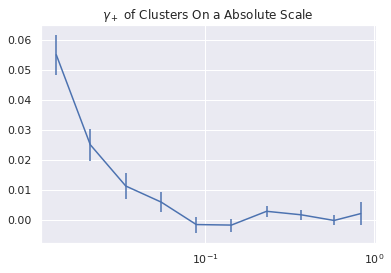

Aggregated xi:
[-17.7808 -16.0556 -11.786  -10.4142   4.4875   8.2437 -19.6411 -14.8328
   1.2861  -2.5903]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1398.4759 -2474.6798 -3524.9601 -5092.6996 -7040.968  -9337.6888
 -9980.2015 -8584.5923 -3962.7882  -222.4731]
------------------------------------------------------------------------------
Aggregated npairs:
[ 323.  640. 1042. 1757. 2908. 4807. 6820. 8639. 7297. 1228.]
------------------------------------------------------------------------------
Mean xi:
[-0.055  -0.0251 -0.0113 -0.0059  0.0015  0.0017 -0.0029 -0.0017  0.0002
 -0.0021]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3296 -3.8667 -3.3829 -2.8985 -2.4212 -1.9425 -1.4634 -0.9937 -0.5431
 -0.1812]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

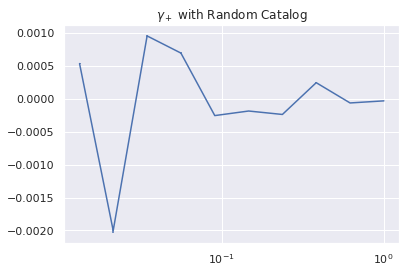

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3424e-06  3.1058e-05 -1.4862e-05 -1.0815e-05  3.9322e-06  2.8539e-06
  3.6650e-06 -3.8305e-06  9.5114e-07  4.5641e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

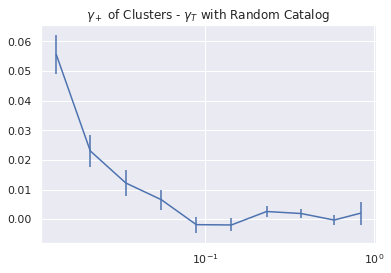

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

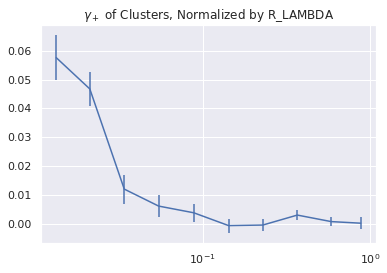

Aggregated xi:
[-10.5396 -23.0881  -9.4127  -7.9518  -8.3708   2.6414   2.9784 -23.1606
  -5.9074  -0.5261]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -789.8819 -1904.6366 -2661.9596 -3817.9641 -5446.0324 -7193.3782
 -8347.6889 -7924.221  -4749.5908  -597.0694]
------------------------------------------------------------------------------
Aggregated npairs:
[ 183.  494.  787. 1312. 2244. 3691. 5646. 7890. 8830. 4451.]
------------------------------------------------------------------------------
Mean xi:
[-0.0576 -0.0467 -0.012  -0.0061 -0.0037  0.0007  0.0005 -0.0029 -0.0007
 -0.0001]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3163 -3.8555 -3.3824 -2.91   -2.4269 -1.9489 -1.4785 -1.0043 -0.5379
 -0.1341]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)